In [9]:
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Markdown, SVG, HTML
import pandas as pd
import altair as alt
import re
import pickle
from utils import seconds_to_ms, ms_to_seconds
from benchmark_result import get_benchmark_results, BenchmarkType, SchedulerType, get_broadcast_source
from benchmarks.utils import echo
from benchmarks.throughput import make_benchmark

In [10]:
#benchmark_results = get_benchmark_results()
from benchmark_result import BenchmarkResult, Result 
with open('saved_results.pkl', 'rb') as saved_results:
    benchmark_results = pickle.load(saved_results)

## ipyparallel benchmark results ##

### time_broadcast

This benchmark comes from benchmaring the runtime of sending and returning different size arrays to different number of engines with the echo function on various scheduler implementations


In [11]:
??echo

Signature: echo(delay=0)
Docstring: <no docstring>
Source:   
def echo(delay=0):
    def inner_echo(x, **kwargs):
        import time

        if delay:
            time.sleep(delay)
        return x

    return inner_echo
File:      ~/ipyparallel_master_project/benchmarks/utils.py
Type:      function


In [12]:
??make_benchmark

Signature: make_benchmark(get_view)
Docstring: <no docstring>
Source:   
def make_benchmark(get_view):
    # @timing_decorator
    class Benchmark(ThroughputSuite):
        params = [delay, engines, byte_param]

        def __init__(self):
            super().__init__()

        def time_broadcast(self, delay, engines, number_of_bytes):
            self.view = get_view(self)
            self.view.apply_sync(
                echo(delay),
                np.array([0] * number_of_bytes, dtype=np.int8),
                targets=slice(engines),
            )

    return Benchmark
File:      ~/ipyparallel_master_project/benchmarks/throughput.py
Type:      function


### Results from running benchmark on 64 cores


In [13]:
source = get_broadcast_source(benchmark_results)[64]

In [14]:
dview = []
for delay, results_for_delay in source.items():
    data = pd.DataFrame(results_for_delay['DirectView']) 
    data['Delay'] = delay
    data['Scheduler name'] = 'DirectView'
    data['Speedup'] = 1
    dview.append(data)
dview = pd.concat(dview)

In [15]:
source
datas = []
for delay, results_for_delay in source.items():
    for scheduler_name, scheduler_results in results_for_delay.items():
        data = pd.DataFrame(scheduler_results) 
        data['Delay'] = delay
        data['Scheduler name'] = scheduler_name
        data['Speedup'] = dview[dview['Delay'] == delay]['Duration in ms'] / data['Duration in ms']
        datas.append(data)
data = pd.concat(datas)
data.head()

,Duration in ms,Number of bytes,Number of engines,Delay,Scheduler name,Speedup
0,39.59,10.0,1.0,0.0,CoalescingBroadcast,3.372064
1,39.53,100.0,1.0,0.0,CoalescingBroadcast,3.480142
2,40.52,1000.0,1.0,0.0,CoalescingBroadcast,3.351431
3,53.52,10000.0,1.0,0.0,CoalescingBroadcast,2.612668
4,110.27,100000.0,1.0,0.0,CoalescingBroadcast,1.490886


### With a delay of 0.0

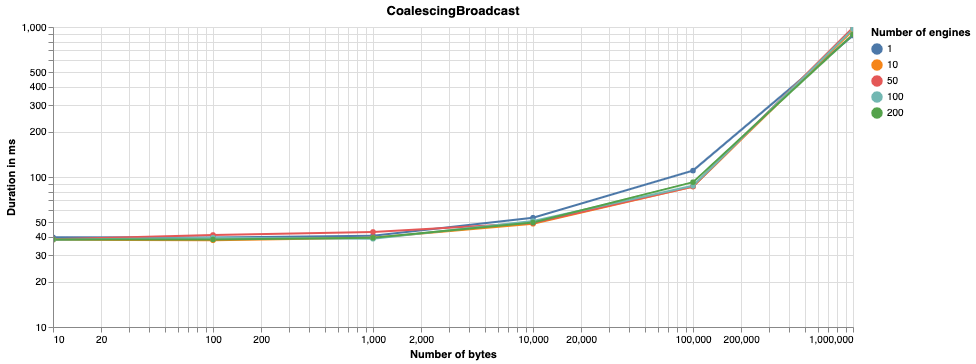

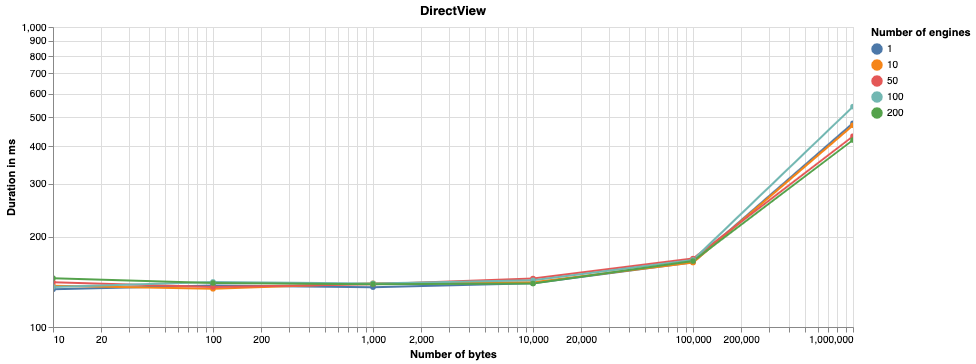

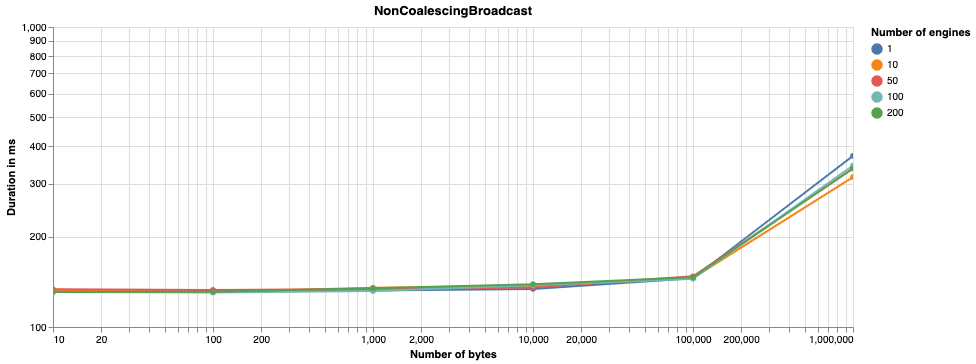

In [16]:
for delay in data['Delay'].unique():    
    display(Markdown(f'### With a delay of {delay}'))
    for scheduler_name in data[data['Delay'] == delay]['Scheduler name'].unique():
        scheduler_data = data[(data['Delay'] == delay) & (data['Scheduler name'] == scheduler_name)]
        alt.Chart(scheduler_data).mark_line(point=True).encode(
            alt.X(
                'Number of bytes',
                scale=alt.Scale(type='log')
            ),
            alt.Y(
                'Duration in ms',
                scale=alt.Scale(type='log')

            ),
            color='Number of engines:N',
            tooltip='Duration in ms',
    
        ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')


## Results for duration[DirectView]/duration[scheduler]

### With a delay of 0.0

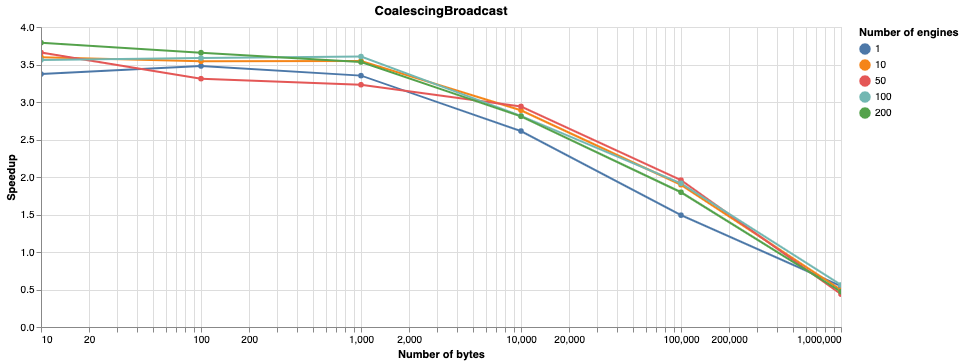

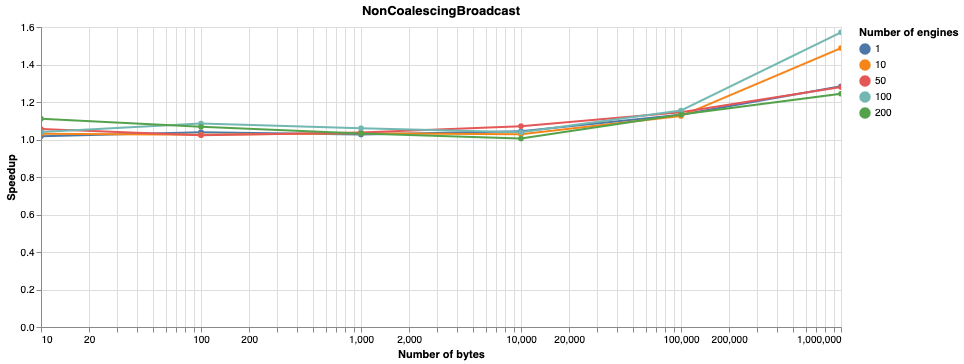

In [17]:
display(Markdown(f'## Results for duration[DirectView]/duration[scheduler]'))
for delay in data['Delay'].unique():    
    display(Markdown(f'### With a delay of {delay}'))
    for scheduler_name in data[data['Delay'] == delay]['Scheduler name'].unique():
        if scheduler_name == 'DirectView':
            continue
        alt.Chart(data[(data['Delay'] == delay) & (data['Scheduler name'] == scheduler_name)]).mark_line(point=True).encode(
            alt.X(
                'Number of bytes',
                scale=alt.Scale(type='log')
            ),
            alt.Y(
                'Speedup',
            ),
            color='Number of engines:N',
            tooltip='Duration in ms',
    
        ).properties(title=scheduler_name, width=800).interactive().display(renderer='svg')

## With 0.0 delay:

### Running on 1.0 engines

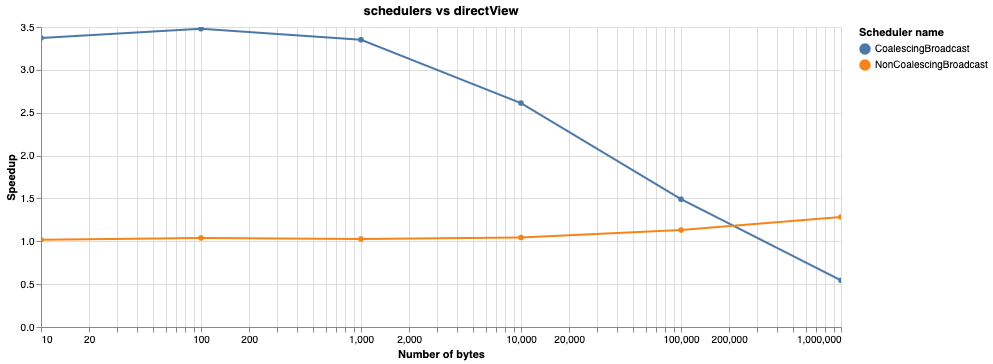

### Running on 10.0 engines

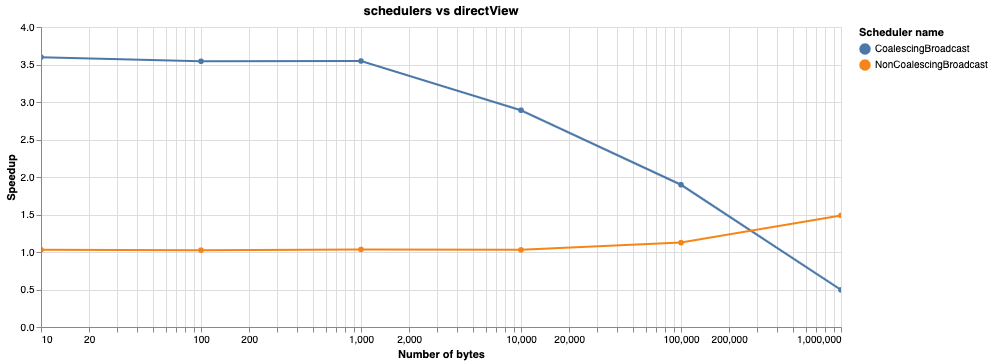

### Running on 50.0 engines

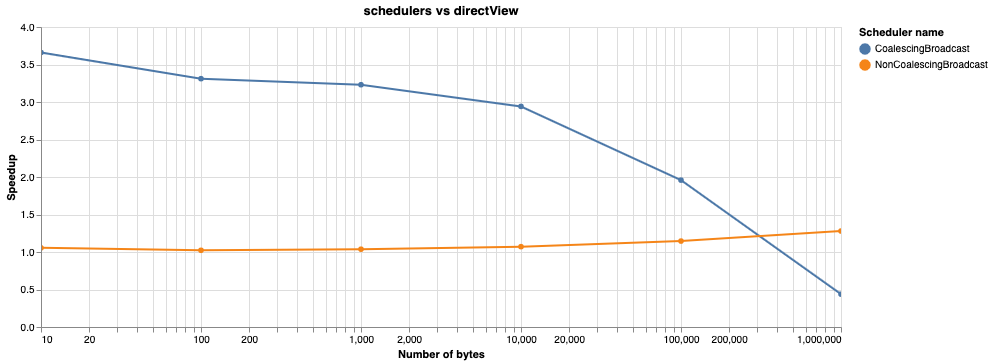

### Running on 100.0 engines

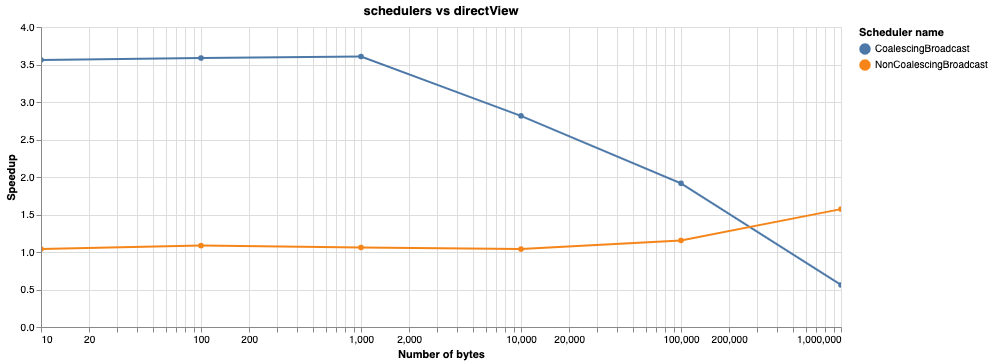

### Running on 200.0 engines

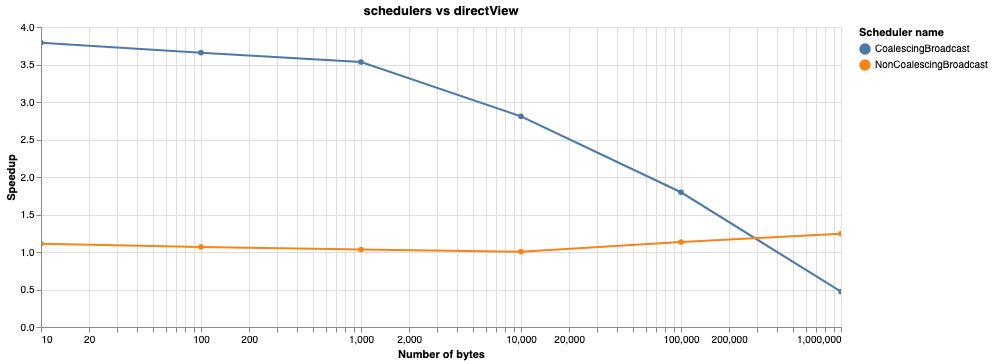

In [18]:

for delay in data['Delay'].unique():
    display(Markdown(f'## With {delay} delay:'))
    for engine in data['Number of engines'].unique():
        display(Markdown(f'### Running on {engine} engines'))
        alt.Chart(data[(data['Delay'] == delay) & (data['Number of engines'] == engine) & (data['Scheduler name'] != 'DirectView')]).mark_line(point=True).encode(
        alt.X(
            'Number of bytes',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Speedup',
        ),
        color='Scheduler name:N',
        tooltip='Duration in ms',
    ).properties(title='schedulers vs directView', width=800).interactive().display(renderer='svg')

## With 0.0 delay:

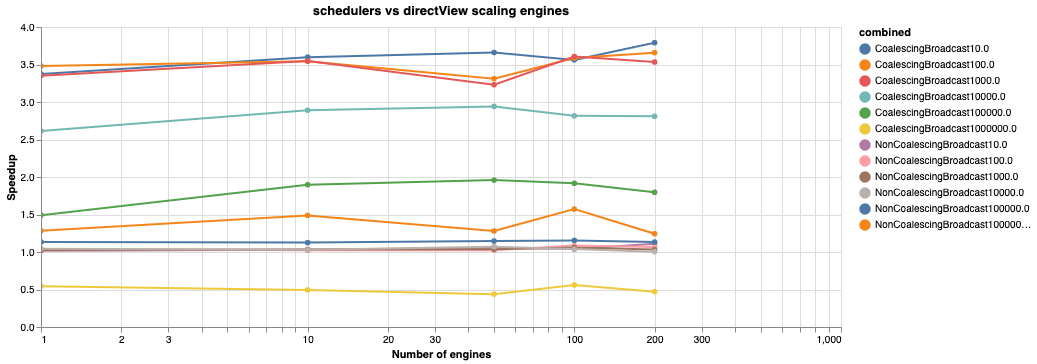

In [28]:
data['combined']=  data['Scheduler name'] + data['Number of bytes'].astype(str)

for delay in data['Delay'].unique():
    display(Markdown(f'## With {delay} delay:'))
    alt.Chart(data[(data['Delay'] == delay) & (data['Scheduler name'] != 'DirectView')]).mark_line(point=True).encode(
        alt.X(
            'Number of engines',
            scale=alt.Scale(type='log')
        ),
        alt.Y(
            'Speedup',
        ),
        color='combined:N',
        tooltip='combined',
    ).properties(title='schedulers vs directView scaling engines', width=800).interactive().display(renderer='svg')


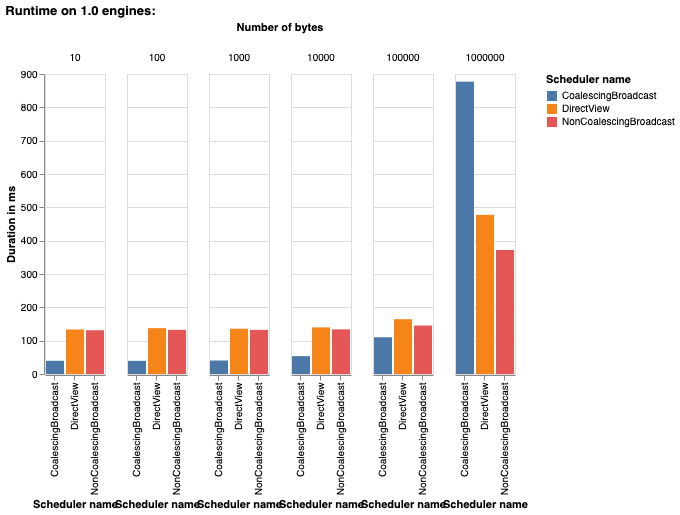

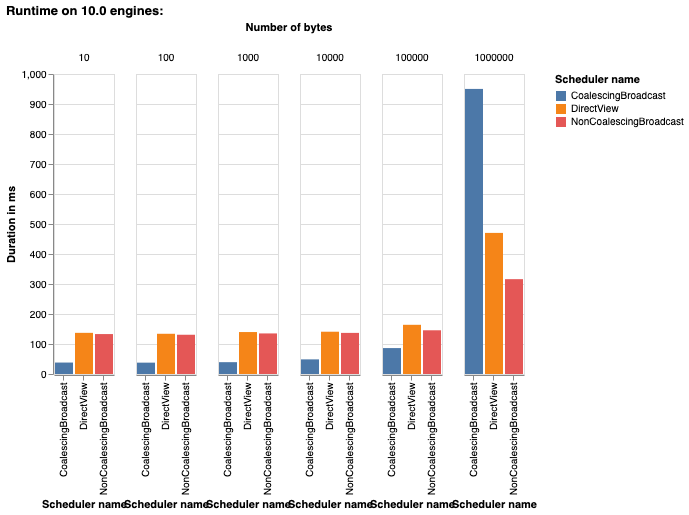

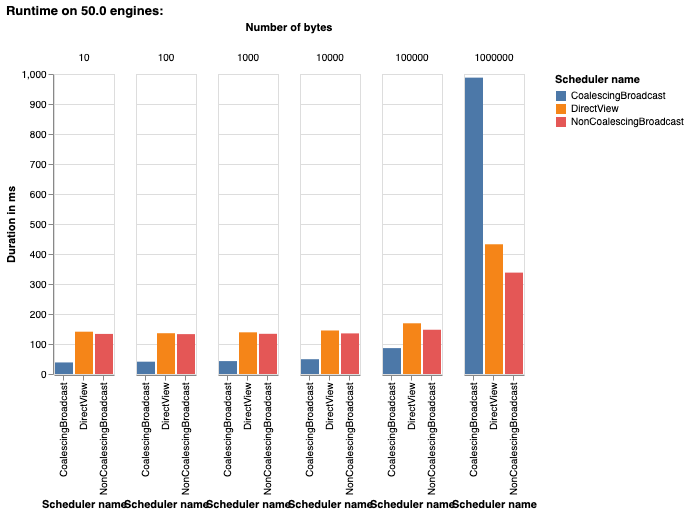

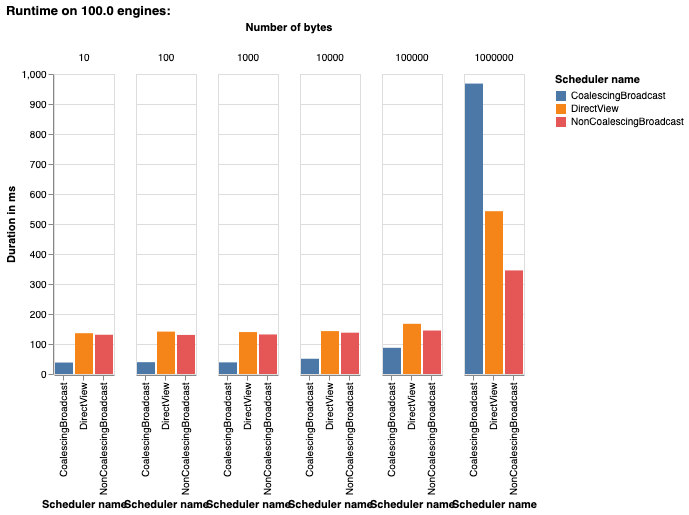

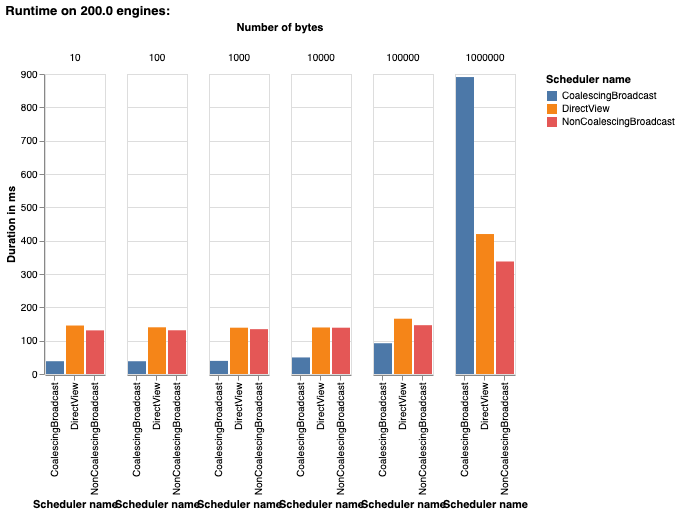

In [13]:
for engine in data['Number of engines'].unique():    
    alt.Chart(data[(data['Delay'] == 0) & (data['Number of engines'] == engine)]).mark_bar().encode(
        x='Scheduler name',
        y='Duration in ms',
        color='Scheduler name:N',
        column='Number of bytes:N'    
    ).properties(title=f'Runtime on {engine} engines:').interactive().display(renderer='svg')